In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import heapq
from collections import OrderedDict
from torch import tensor
import time
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold

In [2]:
# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        # self.fc = nn.Linear(2, 1)
        self.fc = nn.Linear(5, 1)

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Define a toy dataset
def create_dataset():
    X = torch.randn(100, 2)
    y = X[:, 0] + X[:, 1]
    print(X.shape)
    print(y.shape)
    return X, y


In [3]:
# Huffman encoding functions
def build_huffman_tree(freq_map):
    heap = [[weight, [char, ""]] for char, weight in freq_map.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

def encode_with_huffman(text, huffman_tree):
    encoded_text = ""
    for char in text:
        encoded_text += next(item[1] for item in huffman_tree if item[0] == char)
    return encoded_text

def decode_with_huffman(encoded_text, huffman_tree):
    decoded_text = ""
    while encoded_text:
        for item in huffman_tree:
            if encoded_text.startswith(item[1]):
                decoded_text += item[0]
                encoded_text = encoded_text[len(item[1]):]
                break
    return decoded_text

In [ ]:
# Federated Learning
def federated_learning(num_clients, num_epochs):
    global_model = SimpleModel()
    global_optimizer = optim.SGD(global_model.parameters(), lr=0.01)
    prediction_time = []
    for epoch in range(num_epochs):
        for client_id in range(num_clients):
            # Create a new model for the client
            local_model = SimpleModel()
            local_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(local_model.parameters(), lr=0.01)

            # Create a dataset for the client
            X, y = create_dataset()

            start_time = time.time()
            # Train the local model
            for _ in range(10):  # 10 local updates per client
                optimizer.zero_grad()
                y_pred = local_model(X)
                loss = nn.MSELoss()(y_pred, y)
                loss.backward()
                optimizer.step()
            end_time = time.time()
            prediction_time.append(end_time - start_time)

            # Encode the local model's state dictionary with Huffman
            local_model_state_dict_str = str(local_model.state_dict())
            huffman_tree = build_huffman_tree({char: local_model_state_dict_str.count(char) for char in set(local_model_state_dict_str)})
            encoded_state_dict = encode_with_huffman(local_model_state_dict_str, huffman_tree)

            # Transmit encoded model to the server (in practice, this involves secure communication)
            # Here, we'll just decode it for simplicity
            decoded_state_dict = decode_with_huffman(encoded_state_dict, huffman_tree)

            # Update the global model with the received state dictionary
            global_model.load_state_dict(eval(decoded_state_dict))

    return global_model, prediction_time

In [ ]:
if __name__ == "__main__":
    num_clients = 2
    num_epochs = 5
    global_model, prediction_time = federated_learning(num_clients, num_epochs)
    prediction_time_global = sum(prediction_time)
    print("Global model trained using Federated Learning:")
    print(global_model.state_dict())
    print("Time taken = ", prediction_time_global)


torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
Global model trained using Federated Learning:
OrderedDict([('fc.weight', tensor([[-0.0786,  0.0982]])), ('fc.bias', tensor([-0.0537]))])
Time taken =  0.0659027099609375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# Creating a dataset for training the normal model
def create_large_dataset():
    X_list = []
    y_list = []

    for _ in range(num_clients*num_epochs):
        X, y = create_dataset()
        X_list.append(X)
        y_list.append(y)

    X_large = torch.cat(X_list, dim=0)
    y_large = torch.cat(y_list, dim=0)

    return X_large, y_large

# Usage
X_large, y_large = create_large_dataset()

torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])
torch.Size([100, 2])
torch.Size([100])


In [ ]:
# Training a normal model with the large dataset

# Initialize the model
model = SimpleModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Training loop
start_time = time.time()
for epoch in range(5):
  for _ in range(10):
      optimizer.zero_grad()
      y_pred = model(X_large)
      loss = nn.MSELoss()(y_pred, y_large)
      loss.backward()
      optimizer.step()
end_time = time.time()
prediction_time_normal = end_time - start_time

print("Time taken = " , prediction_time_normal)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Time taken =  0.23702454566955566


In [ ]:
# Generate a test dataset
X_test, y_test = create_dataset()

torch.Size([100, 2])
torch.Size([100])


In [ ]:
# Make predictions on the test dataset
with torch.no_grad():
    predictions = global_model(X_test)

# Convert predictions and ground truth to numpy arrays
predictions = predictions.squeeze().cpu().numpy()
y_test = y_test.cpu().numpy()

# Calculate Mean Absolute Error (MAE) and R-squared
mae_global = mean_absolute_error(y_test, predictions)
r2_global = r2_score(y_test, predictions)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae_global:.4f}')
print(f'R-squared (R2): {r2_global:.4f}')


Mean Absolute Error (MAE): 1.1643
R-squared (R2): -0.0070


In [ ]:
# using a Simple Model to do the same predictions

with torch.no_grad():
    predictions = model(X_test)

# Convert predictions and ground truth to numpy arrays
predictions = predictions.squeeze().cpu().numpy()

# Calculate Mean Absolute Error (MAE) and R-squared
mae_normal = mean_absolute_error(y_test, predictions)
r2_normal = r2_score(y_test, predictions)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae_normal:.4f}')
print(f'R-squared (R2): {r2_normal:.4f}')

Mean Absolute Error (MAE): 1.3846
R-squared (R2): -0.4409


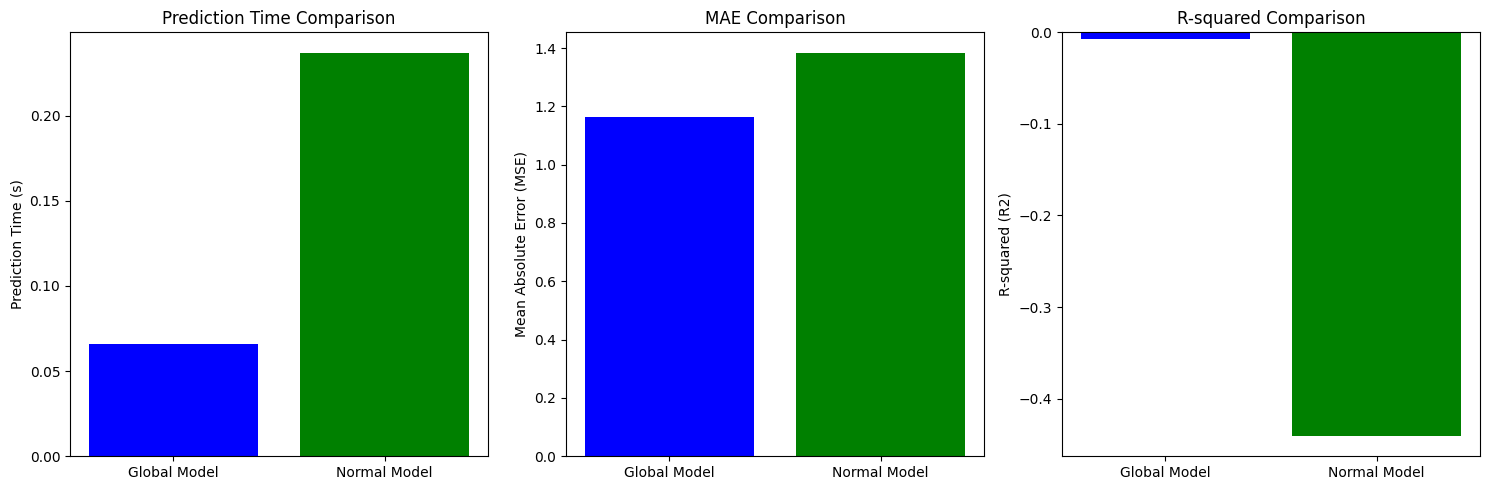

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the following values for two models
model_names = ['Global Model', 'Normal Model']
prediction_times = [prediction_time_global, prediction_time_normal]  # in seconds
mae_values = [mae_global, mae_normal]
r2_values = [r2_global, r2_normal]

# Plotting the comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot prediction times
ax1.bar(model_names, prediction_times, color=['blue', 'green'])
ax1.set_ylabel('Prediction Time (s)')
ax1.set_title('Prediction Time Comparison')

# Plot MSE values
ax2.bar(model_names, mae_values, color=['blue', 'green'])
ax2.set_ylabel('Mean Absolute Error (MSE)')
ax2.set_title('MAE Comparison')

# Plot R-squared values
ax3.bar(model_names, r2_values, color=['blue', 'green'])
ax3.set_ylabel('R-squared (R2)')
ax3.set_title('R-squared Comparison')

plt.tight_layout()
plt.show()


In [4]:
data = pd.read_csv("Student_Performance.csv")
# data['Performance Index'] = data['Performance Index'].astype(int)
data.head()
data.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [5]:
print("data.shape = ", data.shape)
data = data.dropna(how='any', axis=0)
print(data.shape)

data.shape =  (10000, 6)
(10000, 6)


In [6]:
# data[data.isnull()==True]
data = data.dropna()
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [7]:
label_encoder = LabelEncoder()
data['Extracurricular Activities'] = label_encoder.fit_transform(data['Extracurricular Activities'])
data.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities            int64
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [8]:
X = data.drop(["Performance Index"], axis=1)
y = data["Performance Index"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)
print(X_train.shape)

# convert dataframe to pytorch tensor
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

(7000, 5)


In [20]:
# Federated Learning
def new_federated_learning(num_clients, num_epochs):
    global_model = SimpleModel()
    global_optimizer = optim.SGD(global_model.parameters(), lr=0.01)
    prediction_time = []
    i = -1
    for epoch in range(num_epochs):
        for client_id in range(num_clients):
            # Create a new model for the client
            i = i + 1
            local_model = SimpleModel()
            local_model.load_state_dict(global_model.state_dict())
            optimizer = optim.SGD(local_model.parameters(), lr=0.0001)

            # Create a dataset for the client
            X = X_train[700*i : 700*(i+1)+1]
            y = y_train[700*i : 700*(i+1)+1]

            start_time = time.time()
            # Train the local model
            for _ in range(10):  # 10 local updates per client
                optimizer.zero_grad()
                y_pred = local_model(X)
                loss = nn.MSELoss()(y_pred, y)
                loss.backward()
                optimizer.step()
            end_time = time.time()
            prediction_time.append(end_time - start_time)

            # Encode the local model's state dictionary with Huffman
            local_model_state_dict_str = str(local_model.state_dict())
            huffman_tree = build_huffman_tree({char: local_model_state_dict_str.count(char) for char in set(local_model_state_dict_str)})
            encoded_state_dict = encode_with_huffman(local_model_state_dict_str, huffman_tree)

            # print(encoded_state_dict)
            # Transmit encoded model to the server (in practice, this involves secure communication)
            # Here, we'll just decode it for simplicity
            decoded_state_dict = decode_with_huffman(encoded_state_dict, huffman_tree)
            # print(decoded_state_dict)
            # Update the global model with the received state dictionary
            global_model.load_state_dict(eval(decoded_state_dict))

    return global_model, prediction_time

In [21]:
if __name__ == "__main__":
    num_clients = 2
    num_epochs = 5
    global_model, prediction_time = new_federated_learning(num_clients, num_epochs)
    prediction_time_global = sum(prediction_time)
    print("Global model trained using Federated Learning:")
    print(global_model.state_dict())
    print("Time taken = ", prediction_time_global)

Global model trained using Federated Learning:
OrderedDict([('fc.weight', tensor([[0.2405, 0.6717, 0.3682, 0.2511, 0.5727]])), ('fc.bias', tensor([-0.0160]))])
Time taken =  0.30333924293518066


In [25]:
# Training a normal model with the large dataset

# Initialize the model
model = SimpleModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

# Training loop
start_time = time.time()
for epoch in range(5):
  for _ in range(2):
      optimizer.zero_grad()
      y_pred = model(X_train)
      loss = nn.MSELoss()(y_pred, y_train)
      loss.backward()
      optimizer.step()
end_time = time.time()
prediction_time_normal = end_time - start_time

print("Time taken = " , prediction_time_normal)

Time taken =  3.2035014629364014


In [26]:
# Make predictions on the test dataset
with torch.no_grad():
    predictions = global_model(X_test)

# Convert predictions and ground truth to numpy arrays
predictions = predictions.squeeze().cpu().numpy()
y_test = y_test.cpu().numpy()

# Calculate Mean Absolute Error (MAE) and R-squared
mae_global = mean_absolute_error(y_test, predictions)
r2_global = r2_score(y_test, predictions)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae_global:.4f}')
print(f'R-squared (R2): {r2_global:.4f}')

Mean Absolute Error (MAE): 7.8617
R-squared (R2): 0.7475


In [27]:
# using a Simple Model to do the same predictions

with torch.no_grad():
    predictions = model(X_test)

# Convert predictions and ground truth to numpy arrays
predictions = predictions.squeeze().cpu().numpy()

# Calculate Mean Absolute Error (MAE) and R-squared
mae_normal = mean_absolute_error(y_test, predictions)
r2_normal = r2_score(y_test, predictions)

# Print performance metrics
print(f'Mean Absolute Error (MAE): {mae_normal:.4f}')
print(f'R-squared (R2): {r2_normal:.4f}')

Mean Absolute Error (MAE): 7.8996
R-squared (R2): 0.7478


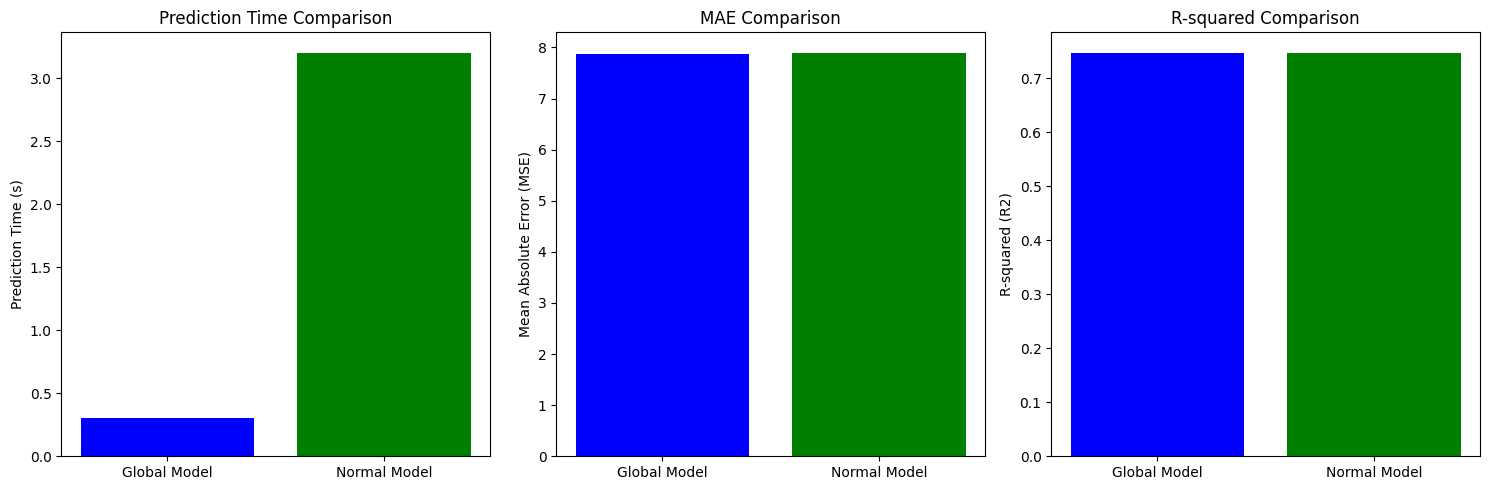

In [28]:
import matplotlib.pyplot as plt

# Assuming you have the following values for two models
model_names = ['Global Model', 'Normal Model']
prediction_times = [prediction_time_global, prediction_time_normal]  # in seconds
mae_values = [mae_global, mae_normal]
r2_values = [r2_global, r2_normal]

# Plotting the comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot prediction times
ax1.bar(model_names, prediction_times, color=['blue', 'green'])
ax1.set_ylabel('Prediction Time (s)')
ax1.set_title('Prediction Time Comparison')

# Plot MSE values
ax2.bar(model_names, mae_values, color=['blue', 'green'])
ax2.set_ylabel('Mean Absolute Error (MSE)')
ax2.set_title('MAE Comparison')

# Plot R-squared values
ax3.bar(model_names, r2_values, color=['blue', 'green'])
ax3.set_ylabel('R-squared (R2)')
ax3.set_title('R-squared Comparison')

plt.tight_layout()
plt.show()
